In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


저장한 kaggle.json 올리기

In [ ]:
!cp /content/drive/MyDrive/KDT/offline/kaggle.json ./

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir yolo_labels
!kaggle datasets download -d awsaf49/vinbigdata-yolo-labels-dataset

  0% 0.00/4.85M [00:00<?, ?B/s]
100% 4.85M/4.85M [00:00<00:00, 73.5MB/s]


In [ ]:
!unzip -d /content/yolo_labels /content/vinbigdata-yolo-labels-dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/yolo_labels/labels/a9f467688d104d27583ea3b3154b1f30.txt  
  inflating: /content/yolo_labels/labels/a9f4c9a4971b3877981e09d4a2ac7fc0.txt  
  inflating: /content/yolo_labels/labels/a9f60e50925ece0b5c00b6bbd9f0825c.txt  
  inflating: /content/yolo_labels/labels/aa0202259a3cba71d0e72468e2d9c3e2.txt  
  inflating: /content/yolo_labels/labels/aa08370eb6114a474adfd0accb6a7238.txt  
  inflating: /content/yolo_labels/labels/aa0a24df022cd97cc1dff4f7ea2131cc.txt  
  inflating: /content/yolo_labels/labels/aa0b79c06462e126d97b73a15187c9c4.txt  
  inflating: /content/yolo_labels/labels/aa1203b1ecab0cddec19f07eb68d4dee.txt  
  inflating: /content/yolo_labels/labels/aa12ea6652b3b8bea37df74e4e127e8f.txt  
  inflating: /content/yolo_labels/labels/aa161d1deb918990c3e196501a714994.txt  
  inflating: /content/yolo_labels/labels/aa1758ce7d9f3cb0bbba72d163ffc69a.txt  
  inflating: /content/yolo_labels/labels/aa17d5312a0fb4a2939436abca7f9579.txt  
  in

In [ ]:
!kaggle datasets download -d awsaf49/vinbigdata-512-image-dataset

100% 2.30G/2.30G [00:18<00:00, 151MB/s]
100% 2.30G/2.30G [00:18<00:00, 136MB/s]


In [ ]:
!unzip -qq /content/vinbigdata-512-image-dataset.zip

## Data pre-processing

In [ ]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow

In [ ]:
train_df = pd.read_csv('/content/vinbigdata/train.csv')
train_df #image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040


**class id 14번(normal) 지우기**

In [ ]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True) 
#reset_index: index를 reset시키는데 사용. drop을통해 index로 세팅한 열을 dataframe내에서 삭제할지 여부 결정
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353
...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,3072,3072
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,2304,2880


In [ ]:
temp_df = train_df[['image_id', 'class_name', 'class_id']]
temp_df

,image_id,class_name,class_id
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8
...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13
36093,22672ab82c290c20b86863291e25ef6c,ILD,5
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9


In [ ]:
temp_df.class_id.value_counts()

0     7162
3     5427
11    4842
13    4655
8     2580
7     2483
10    2476
9     2203
6     1247
5     1000
2      960
4      556
1      279
12     226
Name: class_id, dtype: int64

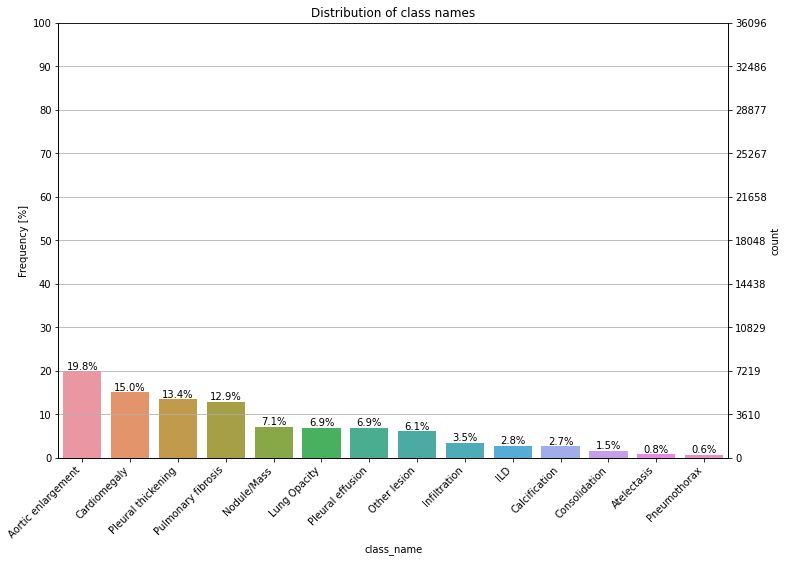

In [ ]:
ncount = len(temp_df)
plt.figure(figsize = (12,8))
ax = sns.countplot(x = 'class_name', data = temp_df, order = temp_df.class_name.value_counts().index)
plt.title('Distribution of class names')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha ='right')
ax2 = ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha = 'center', va = 'bottom')

ax.yaxis.set_major_locator(ticker.LinearLocator(11))

ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

ax2.grid(None)

In [ ]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min) /row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min) /row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max) /row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max) /row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_min + row.x_max)/2,axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_min + row.y_max)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max - row.x_min), axis = 1)
train_df['h'] = train_df.apply(lambda row: (row.y_max - row.y_min), axis = 1)

train_df['area'] = train_df['w']*train_df['h']
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,0.563462,0.686216,0.462500,0.195205,0.090283
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,0.623915,0.305903,0.150608,0.095833,0.014433
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,0.309843,0.128581,0.125984,0.024740,0.003117
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,0.773523,0.472407,0.368053,0.753033,0.277156
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,0.239875,0.721145,0.045950,0.039368,0.001809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,0.104167,0.538194,0.243924,0.694792,2304,2880,0.174045,0.616493,0.139757,0.156597,0.021886
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,0.378581,0.256185,0.435547,0.306315,3072,3072,0.407064,0.281250,0.056966,0.050130,0.002856
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,0.145996,0.265600,0.387695,0.603200,2048,2500,0.266846,0.434400,0.241699,0.337600,0.081598
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,0.002604,0.232639,0.118056,0.602778,2304,2880,0.060330,0.417708,0.115451,0.370139,0.042733


이미지 경로 추가하기

In [ ]:
train_dir = '/content/vinbigdata/train/'
img_path = []
for i in train_df['image_id']:
  img_path.append(train_dir+i+'.png')

train_df['img_path'] = img_path
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_mid,y_mid,w,h,area,img_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,0.563462,0.686216,0.462500,0.195205,0.090283,/content/vinbigdata/train/9a5094b2563a1ef3ff50...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,0.623915,0.305903,0.150608,0.095833,0.014433,/content/vinbigdata/train/051132a778e61a86eb14...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,0.309843,0.128581,0.125984,0.024740,0.003117,/content/vinbigdata/train/1c32170b4af4ce1a3030...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,0.773523,0.472407,0.368053,0.753033,0.277156,/content/vinbigdata/train/0c7a38f293d5f5e4846a...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,0.239875,0.721145,0.045950,0.039368,0.001809,/content/vinbigdata/train/47ed17dcb2cbeec15182...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,0.104167,0.538194,0.243924,0.694792,2304,2880,0.174045,0.616493,0.139757,0.156597,0.021886,/content/vinbigdata/train/b53d1dd80e99ca6bcef9...
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,0.378581,0.256185,0.435547,0.306315,3072,3072,0.407064,0.281250,0.056966,0.050130,0.002856,/content/vinbigdata/train/26d1d5a0ef2e692c6340...
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,0.145996,0.265600,0.387695,0.603200,2048,2500,0.266846,0.434400,0.241699,0.337600,0.081598,/content/vinbigdata/train/22672ab82c290c20b868...
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,0.002604,0.232639,0.118056,0.602778,2304,2880,0.060330,0.417708,0.115451,0.370139,0.042733,/content/vinbigdata/train/db169d0be36123bd55b8...


512 x 512 image bbox 좌표 추가

In [ ]:
train_df['ori_x_min'] = (train_df['x_min']*512).astype('int')
train_df['ori_y_min'] = (train_df['y_min']*512).astype('int')
train_df['ori_x_max'] = (train_df['x_max']*512).astype('int')
train_df['ori_y_max'] = (train_df['y_max']*512).astype('int')

train_df['ori_x_mid'] = (train_df['x_mid']*512).astype('int')
train_df['ori_y_mid'] = (train_df['y_mid']*512).astype('int')
train_df['ori_w'] = (train_df['w']*512).astype('int')
train_df['ori_h'] = (train_df['h']*512).astype('int')

In [ ]:
final_df = train_df.copy()
final_df = final_df[['image_id', 'class_name', 'class_id', 'ori_x_min', 'ori_y_min', 'ori_x_max', 'ori_y_max', 'ori_x_mid', 'ori_y_mid', 'ori_w', 'ori_h']]
final_df

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20
...,...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,53,275,124,355,89,315,71,80
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,193,131,223,156,208,144,29,25
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,74,135,198,308,136,222,123,172
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,1,119,60,308,30,213,59,189


### importing library 

In [ ]:
import re
import cv2 # Albumentation transform을 쓰려면 꼭 cv2 library를 이용해야함.
import time
import random
import warnings

from PIL import Image # PIL = Python Image Library
from sklearn.model_selection import GroupKFold


!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

paddingSize= 0

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 8.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=92f2cae9e65039a08ce327493aa51fec32d76d2bcf262c307161ae1e3ea60fa8
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


### group K fold

- group by image_id
- 예측의 정확도를 확실히 평가하기 위해서는 train set & valid set에 포함된 image가 겹치지 않도록 할 필요가 있기때문에 이를위해 group k fold를 사용하였음

In [ ]:
gkf  = GroupKFold(n_splits = 5)
final_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(final_df, groups = final_df.image_id.tolist())): # cf) tolist한다고 unqiue해지는건 아님
    final_df.loc[val_idx, 'fold'] = fold
final_df.head()

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4


In [ ]:
final_df.groupby('fold')['image_id'].agg(lambda x: x.nunique()).reset_index()
# agg(적용하고 싶은 함수): 함수를 여러 열에 적용하는 함수
# nunique(): 데이터에 고유값들의 수를 출력해주는 함수. (데이터 고유값의 총 수를 알고 싶을때 유용한 함수)

,fold,image_id
0,0,879
1,1,879
2,2,879
3,3,878
4,4,879


In [ ]:
#그냥 가정 설정문으로 가정에 맞지않으면 assertionerror가 발생
IMG_SIZE = 512
assert final_df['ori_x_min'].all() <= IMG_SIZE
assert final_df['ori_y_min'].all() <= IMG_SIZE
assert final_df['ori_x_max'].all() <= IMG_SIZE
assert final_df['ori_y_max'].all() <= IMG_SIZE

In [ ]:
#확인겸
final_df[final_df.ori_y_min == final_df.ori_y_max]

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
11912,a1134e92282815efb505a93105083393,Pleural effusion,10,179,381,206,381,193,381,27,0,1


원래 y_max와 y_min이 별 차이가 나지 않았는데 normalization 후 다시 size(512x512) 재정의시 정수화함에따라 같은 값을 갖게되는 경우가 있었다.
이런 데이터는 삭제하기로 함.

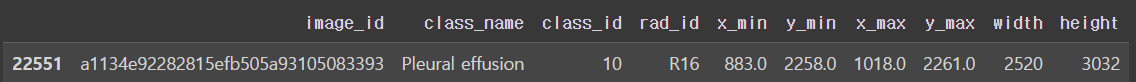

In [ ]:
final_df = final_df[final_df.ori_y_min != final_df.ori_y_max].reset_index()
final_df.head()

,index,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4


In [ ]:
final_df = final_df.drop('index', axis = 1)

In [ ]:
final_df

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...
36090,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,53,275,124,355,89,315,71,80,0
36091,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,193,131,223,156,208,144,29,25,4
36092,22672ab82c290c20b86863291e25ef6c,ILD,5,74,135,198,308,136,222,123,172,4
36093,db169d0be36123bd55b866d6aa73983b,Other lesion,9,1,119,60,308,30,213,59,189,2


In [ ]:
class_dict = dict(set(zip(final_df.class_id, final_df.class_name)))
classes = []
for key in sorted(class_dict.keys()):
    classes.append(class_dict[key])

classes = ['_'] + classes   # adding background
classes

['_',
 'Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

### cv2.putText를 위한 함수 
- id to name

In [ ]:
def label_to_name(id):
  id = int(id)
  id = id-1
  if id == 0:
      return "Aortic enlargement"
  if id == 1:
      return "Atelectasis"
  if id == 2:
      return "Calcification"
  if id == 3:
      return "Cardiomegaly"
  if id == 4:
      return "Consolidation"
  if id == 5:
      return "ILD"
  if id == 6:
      return "Infiltration"
  if id == 7:
      return "Lung Opacity"
  if id == 8:
      return "Nodule/Mass"  
  if id == 9:
      return "Other lesion"
  if id == 10:
      return "Pleural effusion"
  if id == 11:
      return "Pleural thickening"
  if id == 12:
      return "Pneumothorax"
  if id == 13:
      return "Pulmonary fibrosis"
  else:
      return str(id)  

### pytorch 에서의 Deep learning
1.   dataset 객체 class 생성 (pytorch는 model에 들어갈 data의 class와 loader를 정의해주어야함.)
2.   dataloader로 dataset 불러오기
3.   trainset, validationset model에 넣고 model 학습
4.   model로 test set inference


In [ ]:
class VBDDataset(Dataset): # class to load training data
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique() # image 고유 ID
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms # data의 경로와 불러올 데이터들에 augmentation을 적용하기위해 transform 인자를 만듬

    def __getitem__(self, idx): # image index로 item 불러오기

        image_id = self.image_ids[idx]
        # image ID가 같은 dataframe 가져오기
        records = self.df[self.df['image_id'] == image_id]
        # cv2로 image 불러오기
        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        # openCV로 각  color를 저장하는 방식인 BGR을 RGB로 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # 0~1 사이로 scaling
        image /= 255.0
        boxes = records[['ori_x_min', 'ori_y_min', 'ori_x_max', 'ori_y_max']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # list를 torch tensor로 view 변환 (data definition)
        area = torch.as_tensor(area, dtype=torch.float32)
        # all the labels are shifted by 1 to accomodate background
        labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64))
        
        # 모든 인스턴스는 crowd 상태가 아님을 가정
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        # transform 적용
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'])

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
dt = VBDDataset(final_df, train_dir)

In [ ]:
# 이미지 tensor로 바꾸기
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0) # albumentations의 경우는 normalize 후 ToTensorV2 사용
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### 미리 학습된 model로 부터 fine tuning

coco 로 미리 학습 된 model 읽기

In [ ]:
#load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

분류기를 새로운 것을 교체

In [ ]:
num_classes = 15  # 14 classes + background

# 분류기에서 사용할 입력 특징의 차원 정보 얻음
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# A Class for keeping track of average
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

### testing sample

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VBDDataset(final_df, train_dir, get_train_transform())
valid_dataset = VBDDataset(final_df, train_dir, get_valid_transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

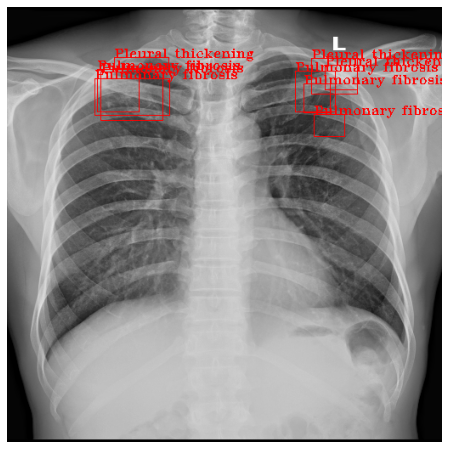

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()
labels= targets[2]['labels'].cpu().numpy().astype(np.int32)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i in range(len(boxes)):
    sample = cv2.rectangle(sample,
                  (boxes[i][0], boxes[i][1]),
                  (boxes[i][2], boxes[i][3]),
                  (220, 0, 0), 1)
    sample = cv2.putText(sample, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])),cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

ax.set_axis_off()
ax.imshow(sample)

### training

In [ ]:
def get_dataloaders(df, trn_idx, val_idx):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataset = VBDDataset(train_, train_dir, get_train_transform())
    valid_dataset = VBDDataset(valid_, train_dir, get_valid_transform())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )
    
    return train_data_loader, valid_data_loader

In [ ]:
def train_model(model, dataloader, device, epochs, optimizer, lr_scheduler, fold):
    
    best_loss = 1e10
    loss_hist = Averager()
    itr = 1
    all_losses = []

    for epoch in range(epochs):
        loss_hist.reset() 
    
        for images, targets, image_ids in dataloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            all_losses.append(loss_value)
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1        
        # saving the model based on training loss for now. - later can be moved to validation
        if loss_hist.value < best_loss:
            best_loss = loss_hist.value
            torch.save(model.state_dict(), f'fasterrcnn_model_{fold}.pt')

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}\n")
        
    return all_losses

In [ ]:
def validate_model(model, dataloader, device):
    print("\n Starting Validation ... ")
    loss_hist = Averager()
    itr = 1

    loss_hist.reset() 

    for images, targets, image_ids in dataloader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    print(f"\nFinal loss: {loss_hist.value}")

In [ ]:
def run_fold(fold):
    print(f"Starting fold {fold}")
    start = time.time()
    trn_idx = final_df[final_df['fold'] != fold].index
    val_idx = final_df[final_df['fold'] == fold].index
    
    
    trainloader, valloader = get_dataloaders(final_df, trn_idx, val_idx)
    
    loss_hist = train_model(model, trainloader, device, epochs, optimizer, lr_scheduler, fold)
    
    # plot training loss
    plt.figure(figsize=(8,5))
    plt.plot(loss_hist)
    plt.title("Training Loss Statistic", size=17)
    plt.xlabel("Iteration", size=15)
    plt.ylabel("Loss Value", size=15)

    plt.show()
    
    validate_model(model, valloader, device)
    
    print(f"Completed Fold {fold} in {round(time.time()-start, 2)} seconds")

In [ ]:
model.to(device)

# set params for model
params = [p for p in model.parameters() if p.requires_grad]

# set optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# set lr scheduler
lr_scheduler = None

# set epochs
epochs = 10

# set folds
num_folds = 5

Starting fold 0
Iteration #50 loss: 1.165140151977539
Iteration #100 loss: 1.2379555702209473
Iteration #150 loss: 0.6830346584320068
Iteration #200 loss: 0.8883285522460938
Iteration #250 loss: 1.10016667842865
Iteration #300 loss: 0.7688009738922119
Iteration #350 loss: 0.5216718912124634
Iteration #400 loss: 0.6151371002197266
Epoch #0 loss: 0.8538310984996232

Iteration #450 loss: 0.9212771654129028
Iteration #500 loss: 0.7681915760040283
Iteration #550 loss: 0.8988922238349915
Iteration #600 loss: 0.858392596244812
Iteration #650 loss: 0.7525734305381775
Iteration #700 loss: 0.5126218795776367
Iteration #750 loss: 0.7834047675132751
Iteration #800 loss: 0.587777316570282
Iteration #850 loss: 0.704698920249939
Epoch #1 loss: 0.7522174748168751

Iteration #900 loss: 0.7720261216163635
Iteration #950 loss: 1.1517146825790405
Iteration #1000 loss: 0.8219655752182007
Iteration #1050 loss: 0.9303770065307617
Iteration #1100 loss: 0.8182961940765381
Iteration #1150 loss: 0.81883519887924

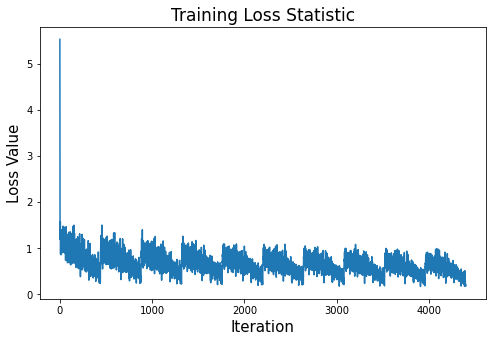


 Starting Validation ... 
Iteration #50 loss: 1.6026499271392822
Iteration #100 loss: 1.0329779386520386
Iteration #150 loss: 1.0473194122314453
Iteration #200 loss: 0.6698647737503052

Final loss: 0.928724081069231
Completed Fold 0 in 3554.32 seconds
Starting fold 1
Iteration #50 loss: 0.557553231716156
Iteration #100 loss: 0.7058529853820801
Iteration #150 loss: 0.5107188820838928
Iteration #200 loss: 0.5906602740287781
Iteration #250 loss: 0.4455888867378235
Iteration #300 loss: 0.5014573335647583
Iteration #350 loss: 0.5626427531242371
Iteration #400 loss: 0.32809337973594666
Epoch #0 loss: 0.6041526337916201

Iteration #450 loss: 0.7746204733848572
Iteration #500 loss: 0.5234135985374451
Iteration #550 loss: 0.8123756647109985
Iteration #600 loss: 0.6423003673553467
Iteration #650 loss: 0.4828357398509979
Iteration #700 loss: 0.7005360126495361
Iteration #750 loss: 0.4172881245613098
Iteration #800 loss: 0.42591792345046997
Iteration #850 loss: 0.5308982729911804
Epoch #1 loss: 0

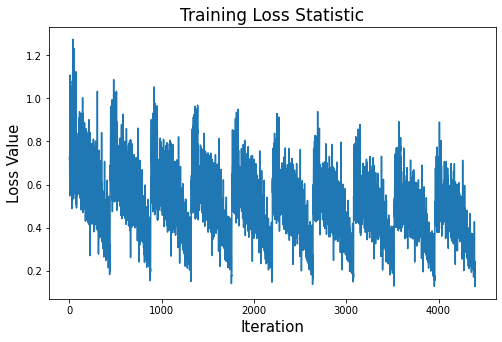


 Starting Validation ... 
Iteration #50 loss: 1.012257695198059
Iteration #100 loss: 0.6807786822319031
Iteration #150 loss: 0.43390175700187683
Iteration #200 loss: 0.3818817734718323

Final loss: 0.8876317678527399
Completed Fold 1 in 3503.48 seconds
Starting fold 2
Iteration #50 loss: 0.48316285014152527
Iteration #100 loss: 0.44134584069252014
Iteration #150 loss: 0.5389730930328369
Iteration #200 loss: 0.5709960460662842
Iteration #250 loss: 0.4166887104511261
Iteration #300 loss: 0.5411815047264099
Iteration #350 loss: 0.36073991656303406
Iteration #400 loss: 0.4350542724132538
Epoch #0 loss: 0.5074912995100022

Iteration #450 loss: 0.5194161534309387
Iteration #500 loss: 0.48251578211784363
Iteration #550 loss: 0.4049384295940399
Iteration #600 loss: 0.4664093852043152
Iteration #650 loss: 0.7058250904083252
Iteration #700 loss: 0.34116441011428833
Iteration #750 loss: 0.5370878577232361
Iteration #800 loss: 0.3872932195663452
Iteration #850 loss: 0.3209180235862732
Epoch #1 lo

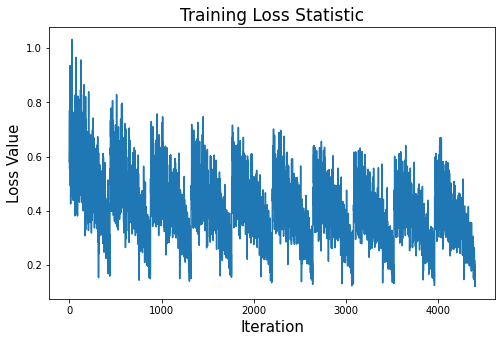


 Starting Validation ... 
Iteration #50 loss: 1.0151692628860474
Iteration #100 loss: 0.5530223846435547
Iteration #150 loss: 0.6334667801856995
Iteration #200 loss: 0.41640400886535645

Final loss: 0.7569833843884143
Completed Fold 2 in 3500.9 seconds
Starting fold 3
Iteration #50 loss: 0.3343091905117035
Iteration #100 loss: 0.4507089853286743
Iteration #150 loss: 0.3127894103527069
Iteration #200 loss: 0.39022865891456604
Iteration #250 loss: 0.4623534679412842
Iteration #300 loss: 0.4022734761238098
Iteration #350 loss: 0.28934523463249207
Iteration #400 loss: 0.2418140023946762
Epoch #0 loss: 0.41570345813577825

Iteration #450 loss: 0.44800347089767456
Iteration #500 loss: 0.4926738142967224
Iteration #550 loss: 0.4666426181793213
Iteration #600 loss: 0.6108344793319702
Iteration #650 loss: 0.4692775011062622
Iteration #700 loss: 0.3731189966201782
Iteration #750 loss: 0.3642677664756775
Iteration #800 loss: 0.21876686811447144
Iteration #850 loss: 0.1864164024591446
Epoch #1 lo

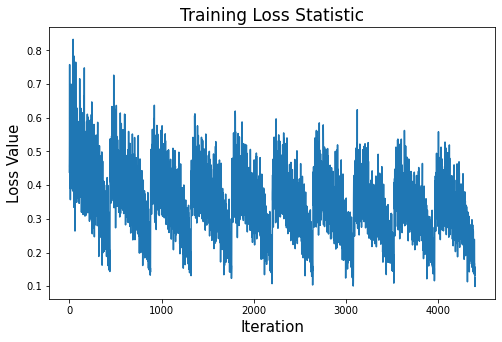


 Starting Validation ... 
Iteration #50 loss: 0.6634362936019897
Iteration #100 loss: 0.28716540336608887
Iteration #150 loss: 0.36148110032081604
Iteration #200 loss: 0.3106618821620941

Final loss: 0.5622213031757962
Completed Fold 3 in 3503.22 seconds
Starting fold 4
Iteration #50 loss: 0.4612980782985687
Iteration #100 loss: 0.4327675700187683
Iteration #150 loss: 0.3357993960380554
Iteration #200 loss: 0.2569133937358856
Iteration #250 loss: 0.4426356852054596
Iteration #300 loss: 0.283038854598999
Iteration #350 loss: 0.29270482063293457
Iteration #400 loss: 0.19038161635398865
Epoch #0 loss: 0.3466719772836024

Iteration #450 loss: 0.3882107436656952
Iteration #500 loss: 0.35247400403022766
Iteration #550 loss: 0.4505048096179962
Iteration #600 loss: 0.3001534640789032
Iteration #650 loss: 0.32774004340171814
Iteration #700 loss: 0.22682303190231323
Iteration #750 loss: 0.3494933247566223
Iteration #800 loss: 0.2077648639678955
Iteration #850 loss: 0.19757293164730072
Epoch #1 

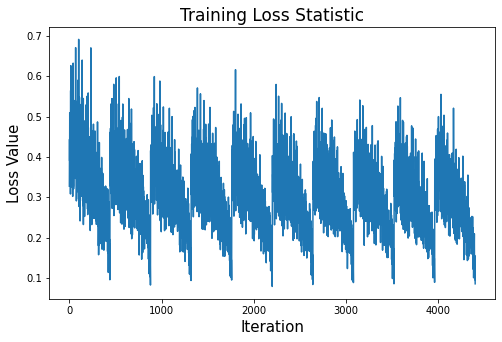


 Starting Validation ... 
Iteration #50 loss: 0.2901724874973297
Iteration #100 loss: 0.5062089562416077
Iteration #150 loss: 0.3553027808666229
Iteration #200 loss: 0.1747654676437378

Final loss: 0.526582494513555
Completed Fold 4 in 3502.72 seconds


In [ ]:
for fold in range(num_folds):
    run_fold(fold)

### visualize model

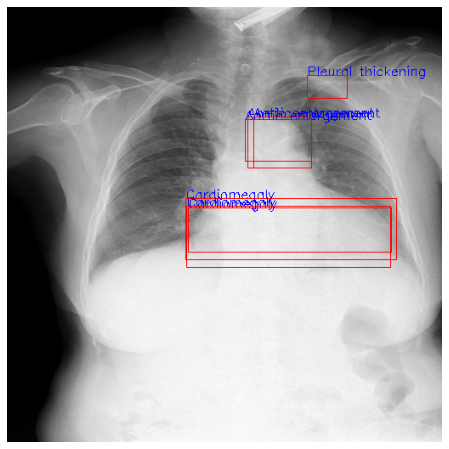

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()
clss = targets[1]['labels'].cpu().numpy().astype(np.int32)

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box, clas in zip(boxes, clss):
    cv2.putText(sample, f"{classes[clas]}", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

### inference

In [ ]:
train_dir = '/content/vinbigdata/train'
test_dir =  '/content/vinbigdata/test'
train_df = pd.read_csv('/content/vinbigdata/train.csv')
test_df = pd.read_csv('/content/vinbigdata/sample_submission.csv')
test_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1


In [ ]:
class VinBigTestDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0 #normalization

        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False) #내 weight upload하려고 이번엔 false

num_classes = 15  # 14 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('/content/fasterrcnn_model_0.pt')) #weight upload
model.eval()

x = model.to(device)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = VinBigTestDataset(test_df, test_dir, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1, #gpu 개수
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

In [ ]:
detection_threshold = 0.4
results = []

with torch.no_grad():

    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            if len(boxes) > 0:
                labels = labels - 1
                labels[labels == -1] = 14

                selected = scores >= detection_threshold

                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]

                if len(boxes) > 0:
                    result = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }


            results.append(result)

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,3 0.9042 175 252 404 316
1,004f33259ee4aef671c2b95d54e4be68,0 0.9493 259 100 311 149
2,008bdde2af2462e86fd373a445d0f4cd,0 0.9772 310 146 384 213 3 0.9230 243 245 428 320
3,009bc039326338823ca3aa84381f17f1,3 0.8338 167 230 400 284
4,00a2145de1886cb9eb88869c85d74080,3 0.9772 187 274 442 351 0 0.6756 271 150 322 201


In [ ]:
sample = images[1].permute(1,2,0).cpu().numpy() #permute:모든 차원의 순서 재배치 (0->1, 1->2, 2->0으로 차원변경)
boxes = outputs[1]['boxes'].data.cpu().numpy().astype(np.int32)
scores = outputs[1]['scores'].data.cpu().numpy()
clss = outputs[1]['labels'].data.cpu().numpy().astype(np.int32)

boxes = boxes[scores >= detection_threshold].astype(np.int32)

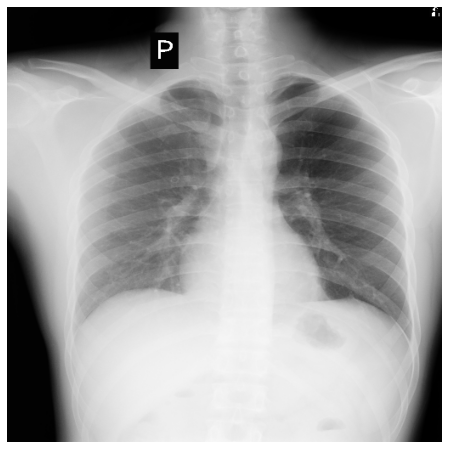

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
test_df.to_csv('Adata_10epoch_submission.csv', index=False)

In [ ]:
!mv fasterrcnn_model_0.pt /content/drive/MyDrive/KDT/offline/project/model_weights/fasterrcnn_Adataset_10e.pt

### inference 한 결과 visulaizing

In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/drive/MyDrive/KDT/offline/project/predictionresult/Adata_10epoch_submission.csv')
test_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,3 0.8381 178 246 417 323 9 0.4269 199 138 322 384
1,004f33259ee4aef671c2b95d54e4be68,0 0.9425 262 100 310 145 0 0.5152 239 100 311 165
2,008bdde2af2462e86fd373a445d0f4cd,0 0.9258 309 145 385 205 3 0.8902 240 240 426 ...
3,009bc039326338823ca3aa84381f17f1,3 0.8387 170 223 388 282 0 0.7617 256 99 309 151
4,00a2145de1886cb9eb88869c85d74080,3 0.9864 184 274 443 357 0 0.8570 269 151 324 197
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0 0.9521 272 103 312 146 3 0.7729 207 236 393 ...
2996,ff9fcc4087ed5e941209aa3fa948e364,0 0.9046 183 130 322 249 0 0.8339 257 124 313 ...
2997,ffaa288c8abca300974f043b57d81521,9 0.8179 199 102 310 379 10 0.6094 370 276 446...
2998,ffc441e0c8b7153844047483a577e7c3,14 1.0 0 0 1 1


In [ ]:
test_dir =  '/content/vinbigdata/test/'

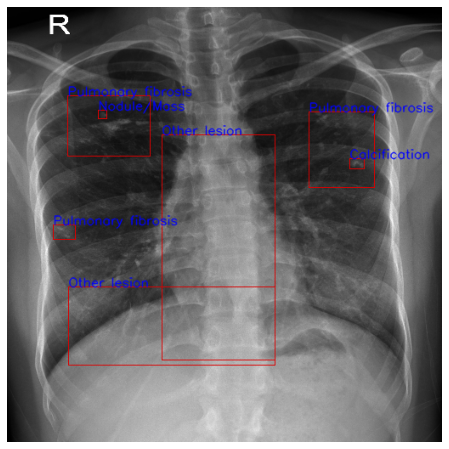

In [ ]:
samp_data = test_df.iloc[13].PredictionString.split(' ')
samp_len = len(samp_data)

img0_labels = []
img0_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
img0 = cv2.imread(test_dir + test_df.iloc[13].image_id +'.png', cv2.IMREAD_COLOR)
img0_labels = [samp_data[i] for i in range(samp_len) if i % 6 == 0]
img0_bboxes = [samp_data[i] for i in range(samp_len) if i % 6 != 0 and i % 6 != 1]

cnt = 0
for cls in img0_labels:
  img0 = cv2.rectangle(img0,
                       (int(img0_bboxes[cnt]), int(img0_bboxes[cnt + 1])),
                       (int(img0_bboxes[cnt + 2]), int(img0_bboxes[cnt + 3])),
                       (220, 0, 0), 1)
  img0 = cv2.putText(img0, label_to_name(int(cls)+1), (int(img0_bboxes[cnt]), int(img0_bboxes[cnt + 1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
  cnt += 4


ax.set_axis_off()
ax.imshow(img0)

In [ ]:
test_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,3 0.9042 175 252 404 316
1,004f33259ee4aef671c2b95d54e4be68,0 0.9493 259 100 311 149
2,008bdde2af2462e86fd373a445d0f4cd,0 0.9772 310 146 384 213 3 0.9230 243 245 428 320
3,009bc039326338823ca3aa84381f17f1,3 0.8338 167 230 400 284
4,00a2145de1886cb9eb88869c85d74080,3 0.9772 187 274 442 351 0 0.6756 271 150 322 201
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0 0.9620 274 104 312 146 8 0.9309 143 227 179 ...
2996,ff9fcc4087ed5e941209aa3fa948e364,0 0.9115 250 122 315 188 0 0.6499 179 125 317 219
2997,ffaa288c8abca300974f043b57d81521,10 0.9509 365 279 434 374 10 0.8760 313 272 44...
2998,ffc441e0c8b7153844047483a577e7c3,14 1.0 0 0 1 1


다시해보기_5kfold

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False) #내 weight upload하려고 이번엔 false

num_classes = 15  # 14 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('/content/drive/MyDrive/KDT/offline/project/new_ver/fasterrcnn_model_4.pt')) #weight upload
model.eval()

x = model.to(device)

In [ ]:
test_dir =  '/content/vinbigdata/test/'

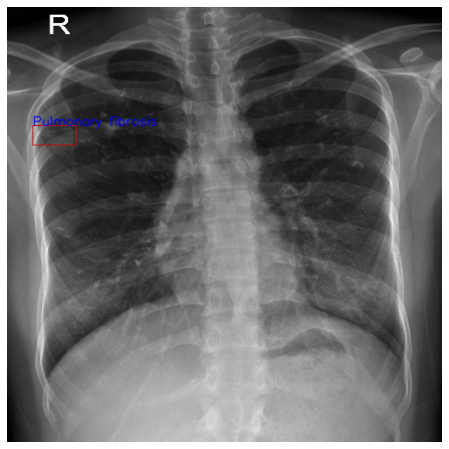

In [ ]:
samp_data = test_df.iloc[13].PredictionString.split(' ')
samp_len = len(samp_data)

img0_labels = []
img0_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
img0 = cv2.imread(test_dir + test_df.iloc[13].image_id +'.png', cv2.IMREAD_COLOR)
img0_labels = [samp_data[i] for i in range(samp_len) if i % 6 == 0]
img0_bboxes = [samp_data[i] for i in range(samp_len) if i % 6 != 0 and i % 6 != 1]

cnt = 0
for cls in img0_labels:
  img0 = cv2.rectangle(img0,
                       (int(img0_bboxes[cnt]), int(img0_bboxes[cnt + 1])),
                       (int(img0_bboxes[cnt + 2]), int(img0_bboxes[cnt + 3])),
                       (220, 0, 0), 1)
  img0 = cv2.putText(img0, label_to_name(int(cls)+1), (int(img0_bboxes[cnt]), int(img0_bboxes[cnt + 1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
  cnt += 4


ax.set_axis_off()
ax.imshow(img0)

In [ ]:
!mv fasterrcnn_model_* /content/drive/MyDrive/KDT/offline/project

In [ ]:
!mv /content/Adata_10epoch_submission.csv /content/drive/MyDrive/KDT/offline/project/new_ver/